In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
from datetime import datetime
import missingno as msno

In [4]:
# read data from .txt file
dataset = read_csv('./data/uci_individual_household_electric_power_consumption_dataset/household_power_consumption.txt',sep=";",na_values='?')

# parse columns Date and Time as DateTime to be used as index
dataset['dt'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'])

In [0]:
# manually specify column names
dataset.columns = ['date', 
                   'time', 
                   'global_active_power', 
                   'global_reactive_power', 
                   'voltage', 
                   'global_current', 
                   'kitchen_active_power', 
                   'laundry_active_power', 
                   'ac_active_power',
                   'dt']
dataset.set_index('dt',inplace=True)
dataset.index = pd.to_datetime(dataset.index)

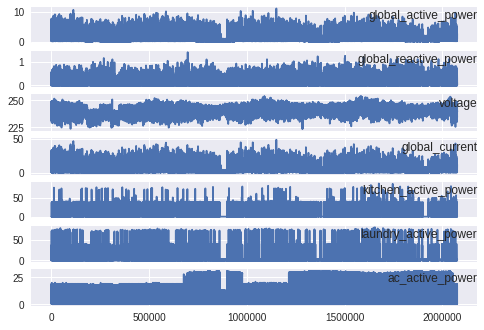

In [0]:
# ploting dataset sample
values = dataset.values

# specify columns to plot
groups = [2,3,4,5,6,7,8]

# plot each column
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

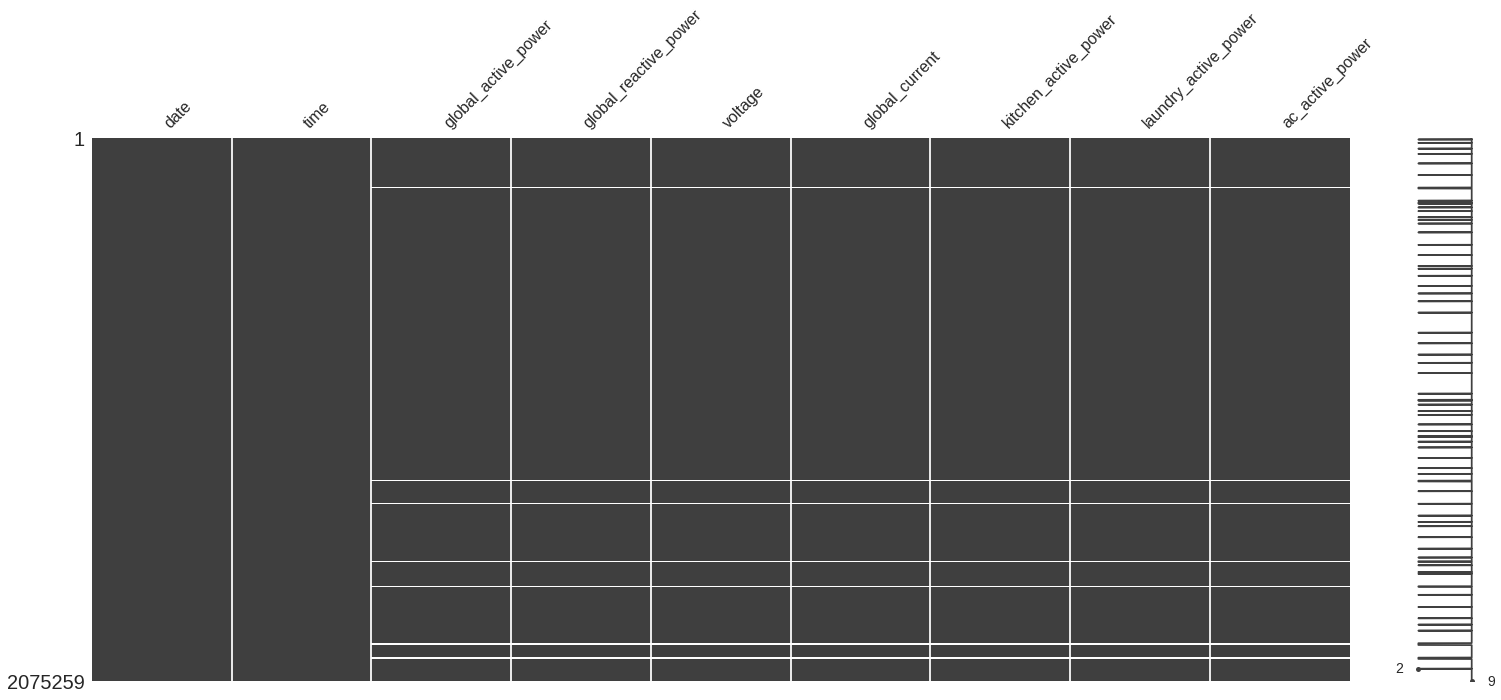

In [0]:
msno.matrix(dataset)

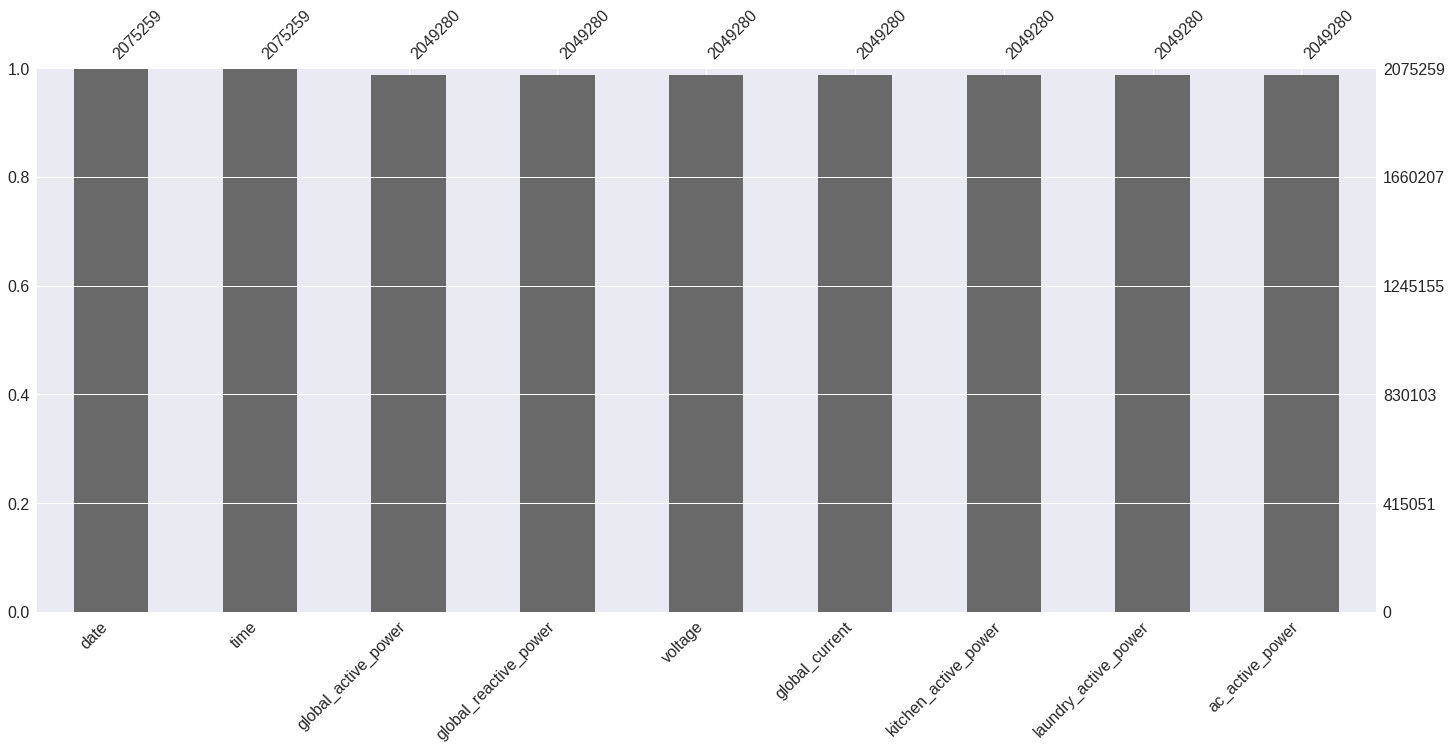

In [0]:
msno.bar(dataset)

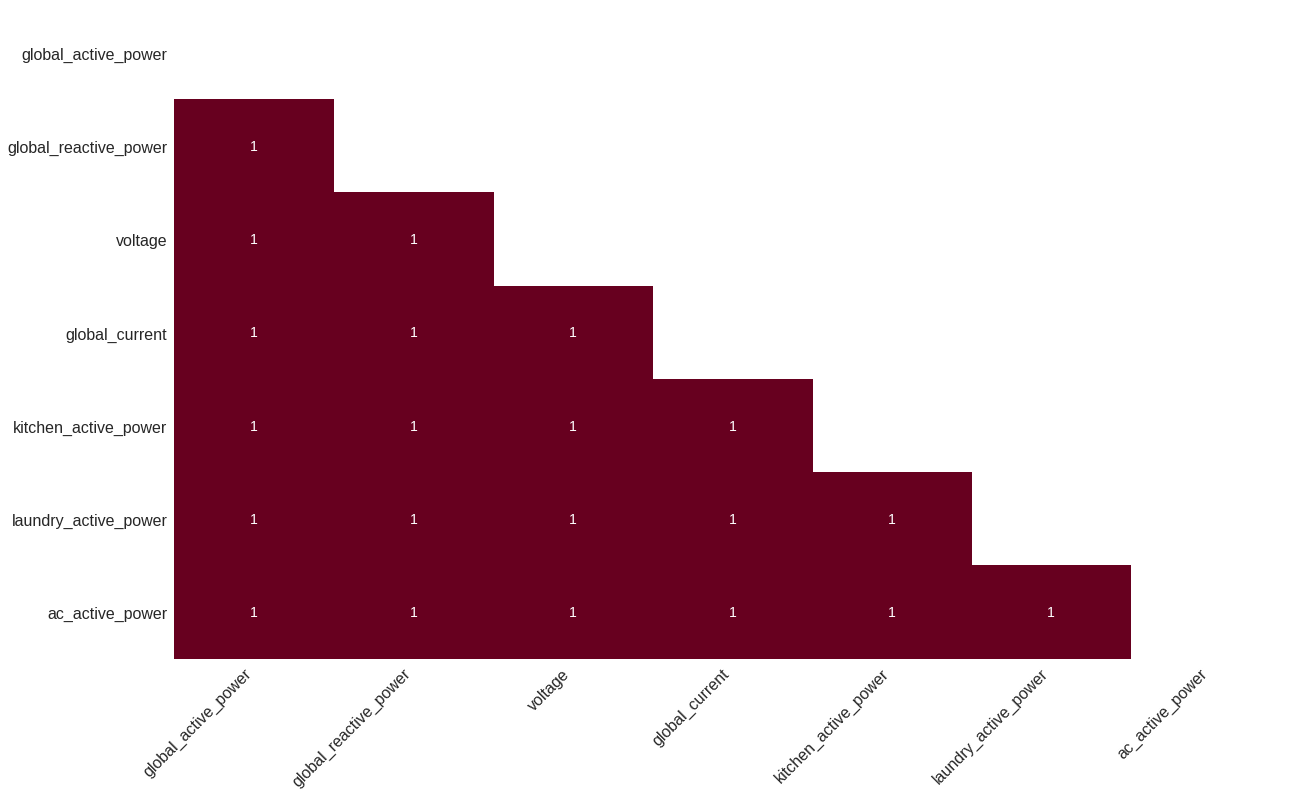

In [0]:
msno.heatmap(dataset)

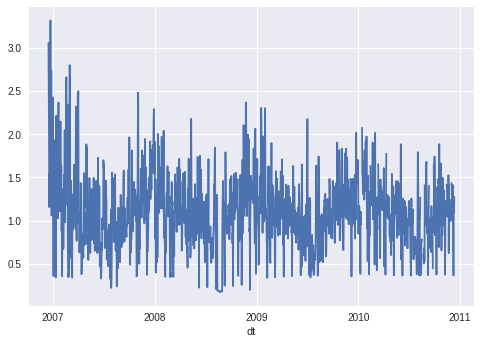

In [0]:
weekly = dataset['global_active_power'].resample('D').mean()
weekly.plot()

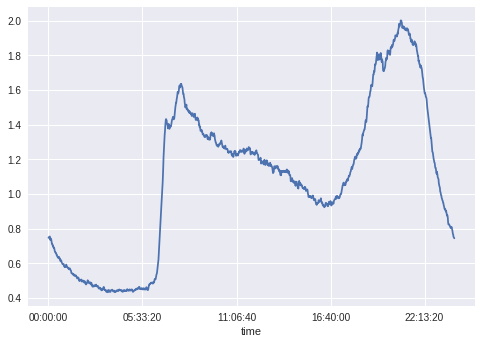

In [0]:
by_time = dataset['global_active_power'].groupby(dataset.index.time).mean()
by_time.plot()

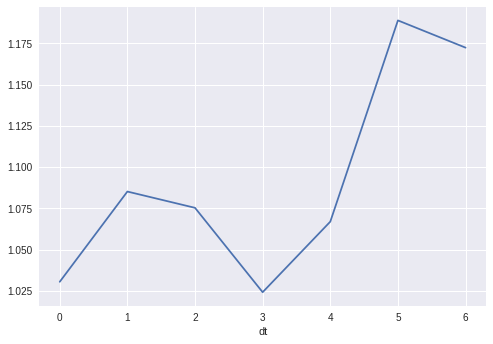

In [0]:
by_time = dataset['global_active_power'].groupby(dataset.index.weekday).mean()
by_time.plot()

In [0]:
sample = dataset
X = sample.drop(['global_active_power', 'Date'], axis=1)
y = sample['global_active_power']

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


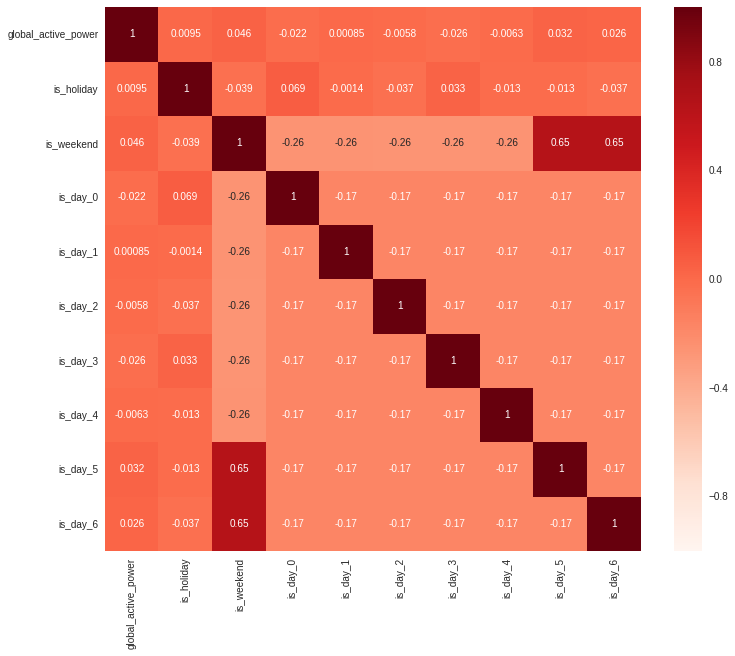

In [0]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = sample.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [0]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const         3.693490e-07
is_holiday    4.089671e-77
is_weekend    3.693490e-07
is_day_0      3.693490e-07
is_day_1      3.693490e-07
is_day_2      3.693490e-07
is_day_3      3.693490e-07
is_day_4      3.693490e-07
is_day_5      3.693490e-07
is_day_6      3.693490e-07
dtype: float64

In [0]:
sample.drop(['Date','is_day_0','is_day_1','is_day_2','is_day_3','is_day_4','is_day_5','is_day_6'],axis=1,inplace=True)

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
values = sample.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values[:,:1])
scaled = np.concatenate((scaled,values[:,1:]),axis=1)
# specify the number of lag hours
n_hours = 2
n_features = 1
n_predictions = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_predictions)

# drop columns we don't want to predict
#cols = list()
#for i in range(1,15):
#      cols.append(i)
#reframed.drop(reframed.columns[cols], axis=1, inplace=True)
reframed = reframed[[reframed.columns[0],reframed.columns[7],reframed.columns[8],reframed.columns[6]]]
print(reframed.head())

   var1(t-2)  var2(t)  var3(t)   var1(t)
2   0.379069      0.0      1.0  0.483186
3   0.481928      0.0      1.0  0.484445
4   0.483186      0.0      1.0  0.329617
5   0.484445      0.0      1.0  0.316490
6   0.329617      0.0      1.0  0.332854


In [0]:
reframed.shape

(2075257, 4)

In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = 2000000
n_val_hours = 50000
n_test_hours = 10000
train = values[:n_train_hours, :]
val = values[n_train_hours:(n_train_hours + n_val_hours), :]
test = values[(n_train_hours + n_val_hours):(n_train_hours + n_val_hours + n_test_hours), :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-n_features], train[:, -n_features:]
val_X, val_y = val[:, :-n_features], val[:, -n_features:]
test_X, test_y = test[:, :-n_features], test[:, -n_features:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(2000000, 1, 3) (2000000, 1) (50000, 1, 3) (50000, 1) (10000, 1, 3) (10000, 1)


In [0]:
# design network
model = Sequential()
model.add(LSTM(100,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=100, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='Treino')
pyplot.plot(history.history['val_loss'], label='Teste')
pyplot.legend()
pyplot.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2000000 samples, validate on 50000 samples
Epoch 1/60
 - 210s - loss: 0.0147 - val_loss: 0.0120
Epoch 2/60
 - 210s - loss: 0.0132 - val_loss: 0.0115
Epoch 3/60
 - 210s - loss: 0.0130 - val_loss: 0.0131
Epoch 4/60
 - 209s - loss: 0.0129 - val_loss: 0.0120
Epoch 5/60
 - 213s - loss: 0.0127 - val_loss: 0.0110
Epoch 6/60
 - 210s - loss: 0.0127 - val_loss: 0.0111
Epoch 7/60
 - 208s - loss: 0.0126 - val_loss: 0.0114
Epoch 8/60
 - 209s - loss: 0.0126 - val_loss: 0.0110
Epoch 9/60
 - 209s - loss: 0.0126 - val_loss: 0.0112
Epoch 10/60
 - 211s - loss: 0.0125 - val_loss: 0.0111
Epoch 11/60
 - 210s - loss: 0.0125 - val_loss: 0.0109
Epoch 12/60
 - 208s - loss: 0.0125 - val_loss: 0.0111
Epoch 13/60
 - 208s - loss: 0.0125 - val_loss: 0.0111
Epoch 14/60
 - 209s - loss: 0.0125 - val_loss: 0.0122
Epoch 15/60
 - 209s - loss: 0.0125 - val_loss: 0.0109
Epoch 16/60
 - 207s - loss:

In [0]:
from numpy import newaxis, empty, delete, append, insert, reshape, concatenate

# make predicitons using actual values for the first 60 hours from test dataset
test_X_actual = test_X[:60]
test_y_actual = test_y[:60]
yhat_actual = model.predict(test_X_actual)

# invert scaling
inv_yhat_actual = scaler.inverse_transform(yhat_actual)
inv_y_actual = scaler.inverse_transform(test_y_actual)

# calculate RMSE
rmse_test = sqrt(mean_squared_error(inv_y_actual, inv_yhat_actual))
print('Test RMSE: %.3f' % rmse_test)


Test RMSE: 0.715


In [0]:
# make predictions using forecasted values for last 60 hours from test dataset
test_X_forecast = test_X[60:]
test_y_forecast = test_y[60:]
yhat_forecast = empty(shape=(1,1))
X = test_X_forecast[0]
X = X[:, newaxis, :]
for i in range(60):
  yhat = model.predict(X)
  X = delete(X,0)
  X = append(X,yhat)
  X = X.reshape(1,1,X.shape[0])
  yhat_forecast = append(yhat_forecast,yhat)
  if i == 0:
    yhat_forecast = delete(yhat_forecast,0)

# invert scaling
yhat_forecast = yhat_forecast.reshape(yhat_forecast.shape[0],1)
inv_yhat_forecast = scaler.inverse_transform(yhat_forecast)
inv_y_forecast = scaler.inverse_transform(test_y_forecast)

# calculate RMSE
rmse_forecast = sqrt(mean_squared_error(inv_y_forecast, inv_yhat_forecast))
print('Forecast RMSE: %.3f' % rmse_forecast)

Forecast RMSE: 1.321


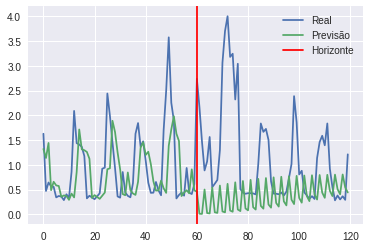

In [0]:
# plot results
Y = concatenate((inv_y_actual, inv_y_forecast), axis=None)
Yhat = concatenate((inv_yhat_actual, inv_yhat_forecast), axis=None)
pyplot.plot(range(len(Y)), Y, label='Real')
pyplot.plot(range(len(Yhat)), Yhat, label='Previsão')
pyplot.axvline(x=60, color='red', label='Horizonte')
pyplot.legend()
pyplot.show()